# Intersection of ellipsoids optimization problem
### Relatively continuous optimization approach
based on the example from <a href="https://arxiv.org/pdf/1710.04718.pdf">paper</a>

In [33]:
import numpy as np
from scipy.optimize import newton
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from collections import defaultdict

In [34]:
np.random.seed(7)

n = 300
m = 300

A = np.zeros(shape=(n, m, m))
b =  np.random.random((n, m))
c = np.random.random(n)

spectral_radiuses = np.array([])

for i in range(n):
    A[i] = squareform(np.random.random(m * (m - 1) // 2))
    eigen_values = np.linalg.eigvals(A[i])
    spectral_radiuses = np.append(spectral_radiuses, np.abs(eigen_values).max())
    print(f"A_{i+1} {('is' if not np.all(eigen_values > 0) else 'isn`t')} semi-definite")

sigma = np.power(spectral_radiuses, 2).max()
rho = 2 * max(np.linalg.norm(A[i] @ b[i], 2) for i in range(n))
gamma = max(np.linalg.norm(b[i], 2)**2 for i in range(n))

print()
print(f'sigma = {sigma}')
print(f'rho = {rho}')
print(f'gamma = {gamma}')

A_1 is semi-definite
A_2 is semi-definite
A_3 is semi-definite
A_4 is semi-definite
A_5 is semi-definite
A_6 is semi-definite
A_7 is semi-definite
A_8 is semi-definite
A_9 is semi-definite
A_10 is semi-definite
A_11 is semi-definite
A_12 is semi-definite
A_13 is semi-definite
A_14 is semi-definite
A_15 is semi-definite
A_16 is semi-definite
A_17 is semi-definite
A_18 is semi-definite
A_19 is semi-definite
A_20 is semi-definite
A_21 is semi-definite
A_22 is semi-definite
A_23 is semi-definite
A_24 is semi-definite
A_25 is semi-definite
A_26 is semi-definite
A_27 is semi-definite
A_28 is semi-definite
A_29 is semi-definite
A_30 is semi-definite
A_31 is semi-definite
A_32 is semi-definite
A_33 is semi-definite
A_34 is semi-definite
A_35 is semi-definite
A_36 is semi-definite
A_37 is semi-definite
A_38 is semi-definite
A_39 is semi-definite
A_40 is semi-definite
A_41 is semi-definite
A_42 is semi-definite
A_43 is semi-definite
A_44 is semi-definite
A_45 is semi-definite
A_46 is semi-defini

In [35]:
h = lambda x: sigma/4 * np.linalg.norm(x, 2)**4 +\
                rho/3 * np.linalg.norm(x, 2)**3 +\
              gamma/2 * np.linalg.norm(x, 2)**2
dh = lambda x: sigma * x * np.linalg.norm(x, 2)**2 + rho * x * np.linalg.norm(x, 2) + gamma * x

def V(y, x):
    return h(y) - h(x) - np.dot(dh(x), y - x)

In [36]:
f = lambda x: (0.5 * (np.expand_dims(x, axis=0) @ A @ x).T + b @ x + c).max()
def df(x):
    i = (0.5 * (np.expand_dims(x, axis=0) @ A @ x).T + b @ x + c).argmax()
    return A[i] @ x + b[i]

In [37]:
def solve_subproblem(c):
    th = newton(
        lambda th: (
            sigma * np.linalg.norm(c, 2)**2 * th**3 +\
            rho * np.linalg.norm(c, 2) * th**2 + gamma * th) - 1, 
        0, tol=1e-10, maxiter=400
    )
    return -th * c

In [38]:
x0 = np.random.random(m) * 1e-3

In [39]:
def optimizer(step):
    def wrapper(x, T, *args, **kwargs):
        state = defaultdict(list)
        state['x'] = x.copy()
        state['x_'] = x.copy()
        
        for t in range(T):
            if not step(state, *args, **kwargs):
                break
        
        return len(state['f-all']), state['x'], {k: np.array(v) for k, v in state.items() if k[0] != 'x'}
    
    return wrapper

In [40]:
@optimizer
def gd(state, L=1):
    """
    Gradient Descent for Relatively Continuous Problems
    """
    state['f-all'].append(f(state['x']))
    state['x'] = solve_subproblem(df(state['x']) / L - dh(state['x']))
    
    return True

In [41]:
R = 10

In [42]:
@optimizer
def alg1(state, L=1, zeta=1.7, R=R, eps=8e-1, last=False):
    """
    Universal Algorithm 1 for Relatively Continuous Problems
    """
    if 'S' in state:
        f_val = f(state['x'] / state['S'][-1])
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (f(x_) <= f(state['x_']) + np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + 3*eps/4):
        L *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    if last:
        state['x'] = state['x_'] * state['S'][-1]
    else:
        state['x'] += state['x_'] / state['L'][-1]
    
    if state['S'][-1] >= 4 * R**2 / eps:
        return False
    
    return True

In [43]:
@optimizer
def alg2(state, L=1, delta=1e-1, zeta=1.7, last=False):
    """
    Universal Algorithm 2 for Relatively Continuous Problems
    """
    if 'S' in state:
        f_val = f(state['x'] / state['S'][-1])
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
    
    if 'delta' in state:
        delta = state['delta'][-1]
        
    L /= zeta
    delta /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (f(x_) <= f(state['x_']) + np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + delta):
        L *= zeta
        delta *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    if last:
        state['x'] = state['x_'] * state['S'][-1]
    else:
        state['x'] += state['x_'] / state['L'][-1]
    
    return True

In [44]:
@optimizer
def alg3(state, L=1, zeta=1.7, R=R, eps=8e-1, last=False):
    """
    Adaptive Algorithm 3 for Relatively Continuous Problems
    """
    if 'S' in state:
        f_val = f(state['x'] / state['S'][-1])
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
        
    L /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (0 <= np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + eps/2):
        L *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    if last:
        state['x'] = state['x_'] * state['S'][-1]
    else:
        state['x'] += state['x_'] / state['L'][-1]
    
    if state['S'][-1] >= 2 * R**2 / eps:
        return False
    
    return True

In [45]:
@optimizer
def alg4(state, L=1, delta=1e-1, zeta=1.7, last=False):
    """
    Adaptive Algorithm 4 for Relatively Continuous Problems
    """
    if 'S' in state:
        f_val = f(state['x'] / state['S'][-1])
    else:
        f_val = f(state['x_'])
    
    state['f'].append(f_val)
    state['f-all'].append(f_val)

    if 'L' in state:
        L = state['L'][-1]
    
    if 'delta' in state:
        delta = state['delta'][-1]
        
    L /= zeta
    delta /= zeta

    x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_']))
    while not (0 <= np.dot(df(state['x_']), x_ - state['x_']) + L * V(x_, state['x_']) + delta):
        L *= zeta
        delta *= zeta
        x_ = solve_subproblem(df(state['x_']) / L - dh(state['x_'])).copy()
        state['f-all'].append(f_val)

    state['x_'] = x_.copy()
    state['L'].append(L)
    
    if 'S' in state:
        S = state['S'][-1]
    else:
        S = 0
        
    state['S'].append(S + 1 / L)
    
    if last:
        state['x'] = state['x_'] * state['S'][-1]
    else:
        state['x'] += state['x_'] / state['L'][-1]
    
    return True

In [46]:
T, x_alg1, state_alg1 = alg1(x0, T=1000, L=1, zeta=1.5, R=R, eps=1e-1)

In [47]:
_, x_alg1_last, state_alg1_last = alg1(x0, T=1000, L=1, zeta=1.5, R=R, eps=1e-1, last=True)

In [48]:
_, x_gd, state_gd = gd(x0, T=T, L=1)

In [49]:
_, x_alg2, state_alg2 = alg2(x0, T=T, delta=1e-1, L=1, zeta=1.5)

In [50]:
_, x_alg2_last, state_alg2_last = alg2(x0, T=T, delta=1e-1, L=1, zeta=1.5, last=True)

In [51]:
T, x_alg3, state_alg3 = alg3(x0, T=1000, L=1, zeta=1.5, R=R, eps=1e-1)

In [52]:
_, x_alg3_last, state_alg3_last = alg3(x0, T=1000, L=1, zeta=1.5, R=R, eps=1e-1, last=True)

In [53]:
_, x_alg4, state_alg4 = alg4(x0, T=T, delta=1e-1, L=1, zeta=1.5)

In [54]:
_, x_alg4_last, state_alg4_last = alg4(x0, T=T, delta=1e-1, L=1, zeta=1.5, last=True)

In [55]:
# Re = np.sqrt(np.linalg.norm(x_gd - x0, 2) * (
#     3*sigma * (np.linalg.norm(x_gd + x0, 2)**2 + 2*np.linalg.norm(x0, 2)**2) +\
#     4*rho * (np.linalg.norm(x_gd, 2) + 2*np.linalg.norm(x0, 2)) + 6*gamma
# ) / (6*T))
# f_opt = np.min(state_gd['f-all']) - Re
f_opt = -1.

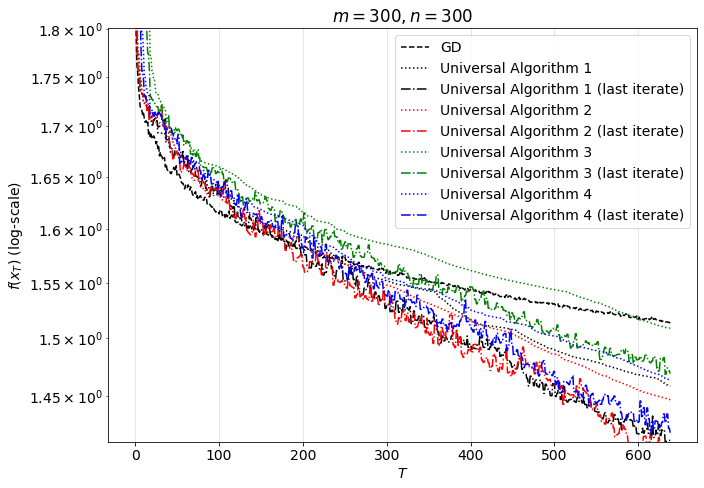

In [57]:
limit_T = min(
    state_gd['f-all'].shape[0],
    state_alg1['f-all'].shape[0],
    state_alg1_last['f-all'].shape[0],
    state_alg2['f-all'].shape[0],
    state_alg2_last['f-all'].shape[0],
    state_alg3['f-all'].shape[0],
    state_alg3_last['f-all'].shape[0],
    state_alg4['f-all'].shape[0],
    state_alg4_last['f-all'].shape[0]
)

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})

plt.semilogy(state_gd['f-all'][:limit_T] - f_opt, 'k--', label='GD')
plt.semilogy(state_alg1['f-all'][:limit_T] - f_opt, 'k:', label='Universal Algorithm 1')
plt.semilogy(state_alg1_last['f-all'][:limit_T] - f_opt, 'k-.', label='Universal Algorithm 1 (last iterate)')
plt.semilogy(state_alg2['f-all'][:limit_T] - f_opt, 'r:', label='Universal Algorithm 2')
plt.semilogy(state_alg2_last['f-all'][:limit_T] - f_opt, 'r-.', label='Universal Algorithm 2 (last iterate)')
plt.semilogy(state_alg3['f-all'][:limit_T] - f_opt, 'g:', label='Universal Algorithm 3')
plt.semilogy(state_alg3_last['f-all'][:limit_T] - f_opt, 'g-.', label='Universal Algorithm 3 (last iterate)')
plt.semilogy(state_alg4['f-all'][:limit_T] - f_opt, 'b:', label='Universal Algorithm 4')
plt.semilogy(state_alg4_last['f-all'][:limit_T] - f_opt, 'b-.', label='Universal Algorithm 4 (last iterate)')

plt.grid(alpha=0.4)
plt.legend()

plt.title(f'$m = {m}, n = {n}$')
plt.ylabel('$f(x_T)$ (log-scale)')
plt.ylim(top=state_gd['f-all'][1] - f_opt, bottom = np.min(state_alg1_last['f-all'][:limit_T]) - f_opt)
plt.xlabel('$T$')

plt.tight_layout()
# plt.savefig('T_m=300.pdf')
plt.show()

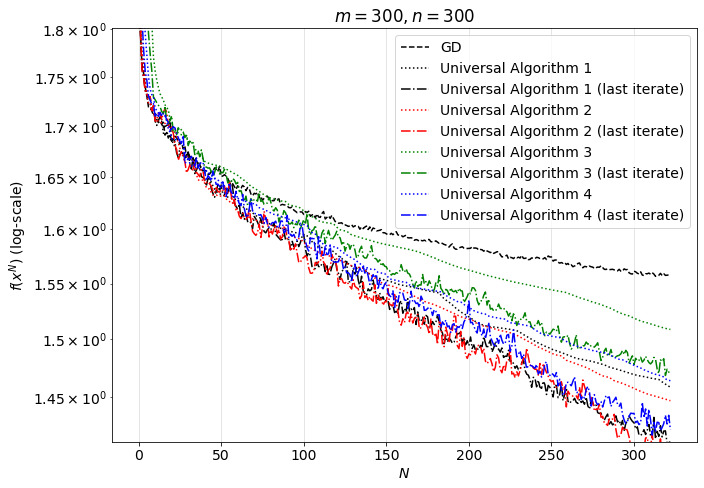

In [58]:
limit_N = min(
    state_gd['f-all'].shape[0],
    state_alg1['f'].shape[0],
    state_alg1_last['f'].shape[0],
    state_alg2['f'].shape[0],
    state_alg2_last['f'].shape[0],
    state_alg1['f'].shape[0],
    state_alg1_last['f'].shape[0],
    state_alg2['f'].shape[0],
    state_alg2_last['f'].shape[0]
)

plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 14})

plt.semilogy(state_gd['f-all'][:limit_N] - f_opt, 'k--', label='GD')
plt.semilogy(state_alg1['f'][:limit_N] - f_opt, 'k:', label='Universal Algorithm 1')
plt.semilogy(state_alg1_last['f'][:limit_N] - f_opt, 'k-.', label='Universal Algorithm 1 (last iterate)')
plt.semilogy(state_alg2['f'][:limit_N] - f_opt, 'r:', label='Universal Algorithm 2')
plt.semilogy(state_alg2_last['f'][:limit_N] - f_opt, 'r-.', label='Universal Algorithm 2 (last iterate)')
plt.semilogy(state_alg3['f'][:limit_N] - f_opt, 'g:', label='Universal Algorithm 3')
plt.semilogy(state_alg3_last['f'][:limit_N] - f_opt, 'g-.', label='Universal Algorithm 3 (last iterate)')
plt.semilogy(state_alg4['f'][:limit_N] - f_opt, 'b:', label='Universal Algorithm 4')
plt.semilogy(state_alg4_last['f'][:limit_N] - f_opt, 'b-.', label='Universal Algorithm 4 (last iterate)')

plt.grid(alpha=0.4)
plt.legend()

plt.title(f'$m = {m}, n = {n}$')
plt.ylabel('$f(x^N)$ (log-scale)')
plt.ylim(top=state_gd['f-all'][1] - f_opt, bottom = state_alg1_last['f'][limit_N-1] - f_opt)
plt.xlabel('$N$')

plt.tight_layout()
# plt.savefig('N_m=300.pdf')
plt.show()